### Showcase FairCLIP Models

# 1. Dataset

The dataset is the Harvard-FairVLMed Dataset [[1]](#1) from Luo et al. (2024) [[2]](#2).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, Image

df = pd.read_csv('../data/Harvard-FairVLMed/data_summary.csv')

The dataset provides data on several features with characteristics relating to fairness, as well as ground truth data on glaucoma diagnosis and a summary of the clinical notes created using GPT-4. 

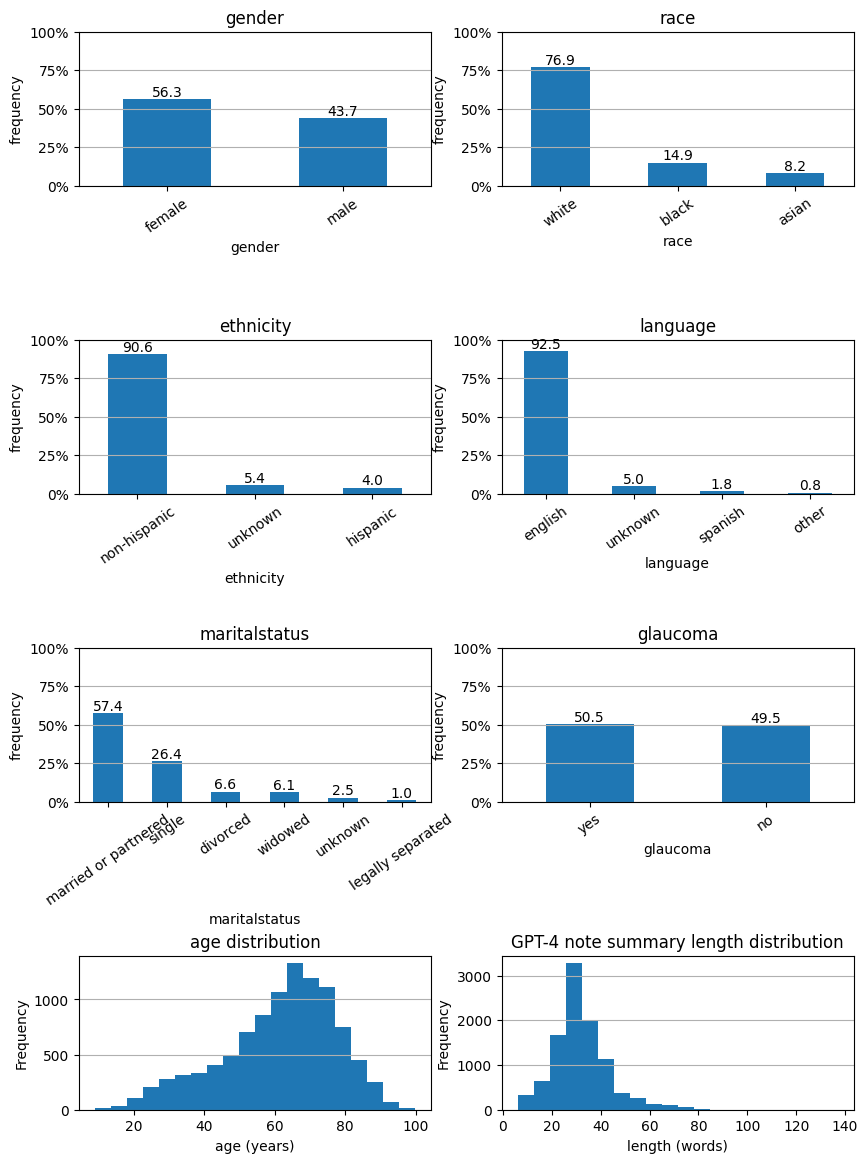

In [3]:
# bar plot glaucoma
l1 = ['gender', 'race', 'ethnicity', 'language', 'maritalstatus', 'glaucoma']
fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(10,14)) 
fig.subplots_adjust(hspace=1)
for cat_n in range(len(l1)):
    counts = df[[l1[cat_n]]].value_counts()
    counts.plot(ax = ax[cat_n//2, cat_n%2], kind = 'bar', ylabel = 'frequency') 
    labels = [str(i[0]) for i in counts.index]
    ax[cat_n//2, cat_n%2].set_xticklabels(labels, rotation=35)
    ax[cat_n//2, cat_n%2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df)))
    ax[cat_n//2, cat_n%2].set_ylim(-1, 10000)
    ax[cat_n//2, cat_n%2].set_title(l1[cat_n])
    ax[cat_n//2, cat_n%2].grid(axis='y')
    # place value on top of bar
    for i in range(len(counts)):
        ax[cat_n//2, cat_n%2].text(i, counts[i], round(counts[i]/sum(counts)*100,1), ha = 'center', va = 'bottom')
df.age.plot(ax = ax[3,0], kind = 'hist', bins = 20, ylabel = 'frequency', title = 'age distribution')
ax[3,0].set_xlabel('age (years)')
ax[3, 0].grid(axis='y')
notes_length = df['gpt4_summary'].apply(lambda x: len(x.split()))
notes_length.plot(ax = ax[3,1], kind = 'hist', bins = 20, ylabel = 'frequency', title = 'GPT-4 note summary length distribution')
ax[3,1].set_xlabel('length (words)')
ax[3, 1].grid(axis='y')

fig.show() 


The dataset also includes Ophthalmoscopy images, which are used by medical professionals to determine prescence of Glaucoma

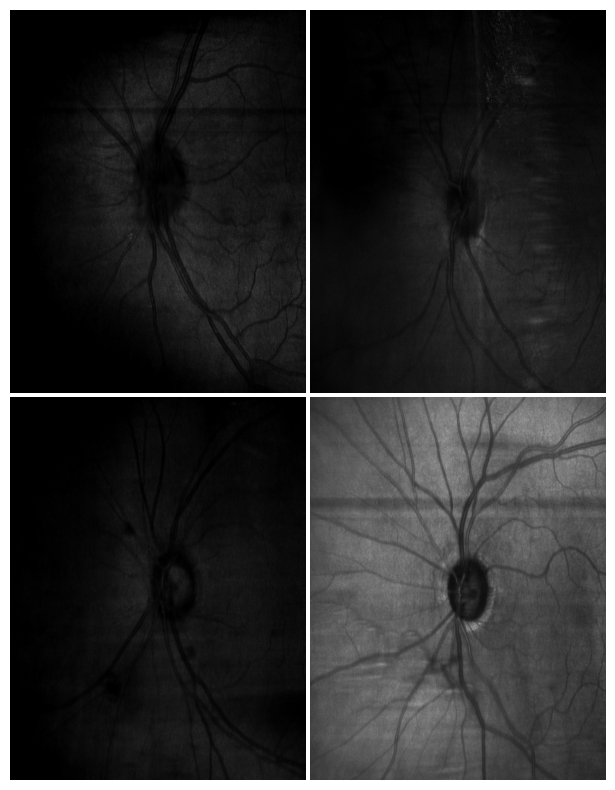

In [4]:
# display images in grid
fig, ax = plt.subplots(2, 2, figsize=(7.7,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
ax[0,0].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00001.jpg'))
ax[0,1].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00002.jpg'))
ax[1,0].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00003.jpg'))
ax[1,1].imshow(plt.imread('../data/Harvard-FairVLMed/Training/slo_fundus_00004.jpg'))

for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')
fig.show()

## Models & Experiments
The models are based on 2 main architectures: CLIP and BLIP2, #TODO (Toevoegen of we BLIP2 ook Fair runnen), using the CLIP architecture a FairCLIP model is also generated. 

In [5]:
df_results = pd.read_csv('../results/best_vit-l14_slo_fundus.csv').loc[3:]
df_results.columns

Index(['epoch', ' acc', ' esacc_attr0', ' esacc_attr1', ' esacc_attr2',
       ' esacc_attr3', '  auc', ' esauc_attr0', ' esauc_attr1', ' esauc_attr2',
       ' esauc_attr3', '  auc_attr0_group0', ' auc_attr0_group1',
       ' auc_attr0_group2', ' auc_attr1_group0', ' auc_attr1_group1',
       ' auc_attr2_group0', ' auc_attr2_group1', ' auc_attr3_group0',
       ' auc_attr3_group1', ' auc_attr3_group2', '  dpd_attr0', ' dpd_attr1',
       ' dpd_attr2', ' dpd_attr3', '  eod_attr0', ' eod_attr1', ' eod_attr2',
       ' eod_attr3', '  std_group_disparity_attr0',
       ' max_group_disparity_attr0', ' std_group_disparity_attr1',
       ' max_group_disparity_attr1', ' std_group_disparity_attr2',
       ' max_group_disparity_attr2', ' std_group_disparity_attr3',
       ' max_group_disparity_attr3', '  path'],
      dtype='object')

In [19]:
def get_results(df_results):
    columns = df_results.columns
    # get columns containing esacc
    race_columns = [col for col in columns if 'attr0' in col]
    gender_columns = [col for col in columns if 'attr1' in col]
    ethnicity_columns = [col for col in columns if 'attr2' in col]
    language_columns = [col for col in columns if 'attr3' in col]

    df_results_race = df_results[race_columns].copy()
    df_results_gender = df_results[gender_columns].copy()
    df_results_ethnicity = df_results[ethnicity_columns].copy()
    df_results_language = df_results[language_columns].copy()

    grouped_params = [(race_columns, df_results_race, 'attr0', 'Race'), (gender_columns, df_results_gender, 'attr1', 'Gender'), (ethnicity_columns, df_results_ethnicity, 'attr2', 'Ethnicity'), (language_columns, df_results_language, 'attr3', 'Language')]

    # get mean and standard deviation for each column and add to df with appended name
    for (esacc_columns, partial_df, attr_idx, attr_name) in grouped_params:
        for col in esacc_columns:
            mean = round(partial_df[col].mean()*100,2)
            std = round(partial_df[col].std()*100,2)
            colname = col.replace('_' + attr_idx, '').strip()
            partial_df.loc[:, colname + '_mean'] = mean
            partial_df.loc[:, colname + '_std'] = std
            partial_df.drop(columns=[col], inplace=True)
        partial_df.insert(0, 'Attribute', attr_name)
        partial_df.insert(0, 'auc_mean', df_results['  auc'].mean())
        partial_df.insert(0, 'auc_std', df_results['  auc'].std())
        partial_df.drop_duplicates(inplace=True)
        if attr_name == 'Race':
            df_results_final = partial_df.copy()
        else:
            df_results_final = pd.concat([df_results_final, partial_df], ignore_index=True)

    # add column Attribute with value Race
    df_results_final.fillna(' ', inplace=True)

    # reorder columns
    order = ['Attribute','dpd_mean', 'dpd_std', 'eod_mean', 'eod_std', 'auc_mean', 'auc_std', 'esauc_mean', 'esauc_std', 'auc_group0_mean', 'auc_group0_std', 'auc_group1_mean', 'auc_group1_std', 'auc_group2_mean', 'auc_group2_std']
    df_results_final = df_results_final[order]
    # round auc mean and std to 2 decimals
    df_results_final['auc_mean'] = round(df_results_final['auc_mean']*100, 2)
    df_results_final['auc_std'] = round(df_results_final['auc_std']*100, 2)

    return df_results_final

def print_results_latex(df_results_final, model_name, half_size=False):
    order = ['Attribute','dpd_mean', 'dpd_std', 'eod_mean', 'eod_std', 'auc_mean', 'auc_std', 'esauc_mean', 'esauc_std', 'auc_group0_mean', 'auc_group0_std', 'auc_group1_mean', 'auc_group1_std', 'auc_group2_mean', 'auc_group2_std']
    if half_size:
        skip = ['dpd_mean', 'dpd_std', 'eod_mean', 'eod_std', 'auc_mean', 'auc_std', 'esauc_mean', 'esauc_std']
        order = [i for i in order if i not in skip]
    df_results_final_ordered = df_results_final[order]
    for x in range(4):
        # store row 1 as list
        row1 = df_results_final_ordered.iloc[x].values.tolist()

        results = []
        for i in range(len(row1)-1):
            if i % 2 == 0:
                results.append(str(row1[i+1]) + ' $\pm$ ' + str(row1[i+2]))
        print(df_results_final.Attribute[x])
        print( ' & ' + model_name + ' & ' +' & '.join(results) + ' \\\\')


df_results = pd.read_csv('../results/best_vit-l14_slo_fundus.csv').loc[3:]
df_results_final = get_results(df_results)
model_name = 'Clip-ViT-L/14'
print_results_latex(df_results_final, model_name, half_size=True)

csv_paths = [['../results/best_vit-l14_slo_fundus_race_FairCLIP.csv', 'FairCLIP-Finetuned-Race'], ['../results/best_vit-l14_slo_fundus_gender_FairCLIP.csv', 'FairCLIP-Finetuned-Gender'], ['../results/best_vit-l14_slo_fundus_ethnicity_FairCLIP.csv','FairCLIP-Finetuned-Ethnicity'], ['../results/best_vit-l14_slo_fundus_language_FairCLIP.csv', 'FairCLIP-Finetuned-Language']]

for path, model_name in csv_paths:
    df_results = pd.read_csv(path).loc[3:]
    df_results_final = get_results(df_results)
    print_results_latex(df_results_final, model_name, half_size=True)


Race
 & Clip-ViT-L/14 & 64.6 $\pm$ 6.64 & 65.74 $\pm$ 8.25 & 62.93 $\pm$ 5.65 \\
Gender
 & Clip-ViT-L/14 & 61.61 $\pm$ 5.24 & 67.69 $\pm$ 7.11 &   $\pm$   \\
Ethnicity
 & Clip-ViT-L/14 & 64.48 $\pm$ 6.14 & 56.24 $\pm$ 3.04 &   $\pm$   \\
Language
 & Clip-ViT-L/14 & 63.97 $\pm$ 6.25 & 68.37 $\pm$ 3.13 & 61.13 $\pm$ 2.87 \\
Race
 & FairCLIP-Finetuned-Race & 69.88 $\pm$ 2.2 & 69.31 $\pm$ 1.53 & 66.13 $\pm$ 2.3 \\
Gender
 & FairCLIP-Finetuned-Race & 64.35 $\pm$ 1.9 & 71.32 $\pm$ 1.83 &   $\pm$   \\
Ethnicity
 & FairCLIP-Finetuned-Race & 67.66 $\pm$ 1.97 & 58.91 $\pm$ 2.66 &   $\pm$   \\
Language
 & FairCLIP-Finetuned-Race & 67.23 $\pm$ 1.95 & 62.88 $\pm$ 3.27 & 63.57 $\pm$ 3.6 \\
Race
 & FairCLIP-Finetuned-Gender & 69.07 $\pm$ 2.8 & 69.87 $\pm$ 2.95 & 64.32 $\pm$ 2.08 \\
Gender
 & FairCLIP-Finetuned-Gender & 63.39 $\pm$ 2.26 & 70.15 $\pm$ 2.01 &   $\pm$   \\
Ethnicity
 & FairCLIP-Finetuned-Gender & 66.54 $\pm$ 2.17 & 57.94 $\pm$ 0.74 &   $\pm$   \\
Language
 & FairCLIP-Finetuned-Gender & 6

## References
<a id="1">[1]</a> 
https://ophai.hms.harvard.edu/datasets/harvard-fairvlmed10k

<a id="2">[2]</a> 
Luo, Y., Shi, M., Khan, M. O., Afzal, M. M., Huang, H., Yuan, S., ... & Wang, M. (2024). Fairclip: Harnessing fairness in vision-language learning. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 12289-12301).